In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib as plt
# Library that downloads historical market data from Yahoo! Finance in a Pythonic way since Yahoo! Finance
# decommissioned their historical market data API
import yfinance as yf

In [2]:
# Create a function to get the stock data for a list of symbol(s) with specific start and end dates
## The function automatically puts the data into a DataFrame, concatenates each ticker dataframe together, and
## indexes it by Date then Symbol
def get_stock_data(symbol_list, start=None, end=None):
    output = pd.DataFrame()
    for symbol in symbol_list:
        df = yf.download(symbol, start, end, auto_adjust=True)
        df["Symbol"] = symbol
        df = df.reset_index(["Date"])
        df = df.set_index(["Date", "Symbol"])
        output = pd.concat([output, df], axis=0)
    return output.sort_index()

In [3]:
# Pull the updated stock data from Yahoo! Finance using the yfinance library for our designated time frame
stocks = get_stock_data(["AAPL", "AMZN", "FB", "GOOGL", "MSFT"], start="2014-01-01", end=None)
print(stocks.tail(10))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                          Open         High          Low        Close  \
Date       Symbol                                                       
2019-12-05 AAPL     263.790009   265.890015   262.730011   265.579987   
           AMZN    1763.500000  1763.500000  1740.000000  1740.479980   
           FB       199.860001   201.289993   198.210007   199.360001   
           GOOGL   1327.000000  1327.979980  1314.319946  1326.959961   
           MSFT     150.050003   150.320007   149.479996   149.929993   
2019-12-06 AAPL     267.480011   271.000000   267.299988   270.709991   
           AMZN    1751.199951  1754.400024  1740.130005  1751.599976  

In [4]:
# Create a DataFrame to hold all of the indicators that will be used in the model to predict future stock prices
indicators = pd.DataFrame(index=stocks.index)

# Calculate the ratio of the change in volume from the previous day
indicators["volume_change_ratio"] = stocks.groupby(level="Symbol").Volume.diff(1) / stocks.groupby(level="Symbol")\
                                    .shift(1).Volume
# Calculate the percentage price change in the stock on a rolling 5 day basis
indicators["5_day_momentum"] = stocks.groupby(level="Symbol").Close.pct_change(5)

In [5]:
# 12 day, 26 day, 50 day, and 200 day exponential moving averages
ema_12_day = lambda x: x.ewm(span=12).mean()
ema_26_day = lambda x: x.ewm(span=26).mean()
ema_50_day = lambda x: x.ewm(span=50).mean()
ema_200_day = lambda x: x.ewm(span=200).mean()

# Daily closing price vs. 50 day exponential moving average
indicators["50_day_ema"] = stocks.Close / stocks.Close.groupby(level="Symbol").apply(ema_50_day) - 1
# Daily closing price vs. 200 day exponential moving average
indicators["200_day_ema"] = stocks.Close / stocks.Close.groupby(level="Symbol").apply(ema_200_day) - 1

# The moving average convergence divergence (macd) shows the relationship between the 12 and 26 day exponential moving
# averages by revealing changes in the strength, direction, momentum, and duration of a trend
indicators["macd"] = (stocks.Close / stocks.Close.groupby(level="Symbol").apply(ema_12_day) - 1) - \
                      (stocks.Close / stocks.Close.groupby(level="Symbol").apply(ema_26_day) - 1)

In [6]:
# Volume percentage change over the previous 5 day rolling period
vol_pct_change = lambda x: x.pct_change(5)
indicators["5_day_vol_change"] = stocks.groupby(level="Symbol").Volume.apply(vol_pct_change)

# Intraday percentage change from opening price to closing price each day
indicators["intraday_move"] = (stocks.groupby(level="Symbol").Close.shift(0) - stocks.groupby(level="Symbol").Open
                               .shift(0)) / stocks.groupby(level="Symbol").Open.shift(0)

print(indicators.tail(30))

                   volume_change_ratio  5_day_momentum  50_day_ema  \
Date       Symbol                                                    
2019-11-29 AAPL              -0.285396        0.019999    0.083590   
           AMZN              -0.364291        0.038099    0.013623   
           FB                -0.373051        0.018744    0.052195   
           GOOGL             -0.319332        0.003038    0.028684   
           MSFT              -0.211210        0.012711    0.052632   
2019-12-02 AAPL               1.026857        0.009092    0.068085   
           AMZN               1.040969        0.020553    0.002705   
           FB                 0.440590        0.004426    0.040355   
           GOOGL              1.072957       -0.003718    0.016006   
           MSFT               1.289197       -0.000267    0.038282   
2019-12-03 AAPL               0.211068       -0.025979    0.047027   
           AMZN              -0.138756       -0.002187   -0.003696   
           FB       

In [7]:
# Use a rolling 200 day window to calculate the z-scores for each ticker
## Use of a specified period prevents the z-score from using the mean and std dev from the entire time period of the data
z_score = lambda x: (x - x.rolling(window=200, min_periods=20).mean()) / x.rolling(window=200, min_periods=20).std()
indicators["z_score"] = stocks.groupby(level="Symbol").Close.apply(z_score)
indicators.z_score.unstack().plot.kde(title='Z-score (accurate)')
print(indicators["z_score"].tail(15))

Date        Symbol
2019-12-04  AAPL      2.052805
            AMZN     -0.628620
            FB        1.311989
            GOOGL     1.950074
            MSFT      1.692860
2019-12-05  AAPL      2.169875
            AMZN     -0.876104
            FB        1.365806
            GOOGL     2.045139
            MSFT      1.689180
2019-12-06  AAPL      2.328807
            AMZN     -0.762237
            FB        1.514841
            GOOGL     2.200227
            MSFT      1.844154
Name: z_score, dtype: float64


In [8]:
indicators.columns

Index(['volume_change_ratio', '5_day_momentum', '50_day_ema', '200_day_ema',
       'macd', '5_day_vol_change', 'intraday_move', 'z_score'],
      dtype='object')

In [9]:
# Create a DataFrame to hold the stock price movement predictions
outcomes = pd.DataFrame(index=stocks.index)

# Calculate the next day, the next 5 day, and the next 20 day percentage change based on closing price
## For the purposes of this model, we will be using these outcomes to predict the directional price change, 
## not necessarily using the prediction as an indication of magnitude of price change
outcomes["day_1"] = (stocks.groupby(level="Symbol").Close.shift(-1) - stocks.groupby(level="Symbol").Close
                               .shift(0)) / stocks.groupby(level="Symbol").Open.shift(0)
outcomes["day_5"] = (stocks.groupby(level="Symbol").Close.shift(-5) - stocks.groupby(level="Symbol").Close
                               .shift(0)) / stocks.groupby(level="Symbol").Open.shift(0)
outcomes["day_20"] = (stocks.groupby(level="Symbol").Close.shift(-20) - stocks.groupby(level="Symbol").Close
                               .shift(0)) / stocks.groupby(level="Symbol").Open.shift(0)

print(outcomes.tail(30))

                      day_1     day_5  day_20
Date       Symbol                            
2019-11-29 AAPL   -0.011590  0.012978     NaN
           AMZN   -0.010562 -0.027066     NaN
           FB     -0.009623 -0.002927     NaN
           GOOGL  -0.011656  0.027017     NaN
           MSFT   -0.012032  0.002433     NaN
2019-12-02 AAPL   -0.017623       NaN     NaN
           AMZN   -0.006451       NaN     NaN
           FB     -0.004354       NaN     NaN
           GOOGL   0.004514       NaN     NaN
           MSFT   -0.001581       NaN     NaN
2019-12-03 AAPL    0.008865       NaN     NaN
           AMZN   -0.005267       NaN     NaN
           FB     -0.000557       NaN     NaN
           GOOGL   0.018926       NaN     NaN
           MSFT    0.003661       NaN     NaN
2019-12-04 AAPL    0.014709       NaN     NaN
           AMZN   -0.011392       NaN     NaN
           FB      0.003250       NaN     NaN
           GOOGL   0.006140       NaN     NaN
           MSFT    0.000533       

In [10]:
# Identify the X and y variables for the linear regression
X = indicators
y = outcomes.day_5

# Combine X and y into a DataFrame to drop the NaN and infinity values so both variables have the same number of obs
Xy = X.join(y).dropna()
Xy = Xy.replace([np.inf, -np.inf], np.nan).dropna()
y = Xy[y.name]
X = Xy[X.columns]

print(X.shape)
print(y.shape)

(7350, 8)
(7350,)


In [11]:
# Run a linear regression using all of the indicators
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

# Compute the R-Squared and the model coefficients for each indicator
print(f"R-Squared: {model.score(X, y)}")
print(f"Coefficients: ")
print(pd.Series(model.coef_, index=X.columns))
## 50_day_ema and macd look to be our most meaningful indicators

R-Squared: 0.014471385824255445
Coefficients: 
volume_change_ratio    0.000178
5_day_momentum         0.024904
50_day_ema            -0.234314
200_day_ema           -0.016194
macd                  -0.530446
5_day_vol_change      -0.001576
intraday_move         -0.005569
z_score                0.001149
dtype: float64


In [12]:
# Create a variable to hold the quarterly retrain dates
retrain_dates = X.resample("Q", level="Date").mean().index.values[:-1]

# Create the walk forward prediction model using the retrain dates 
models = pd.Series(index=retrain_dates)
for date in retrain_dates:
    X_train = X.xs(slice(None, date), level="Date", drop_level=False)
    y_train = y.xs(slice(None, date), level="Date", drop_level=False)
    model = LinearRegression()
    model.fit(X_train, y_train)
    models.loc[date] = model

start_dates = models.index 
end_dates = models.index[1:].append(pd.to_datetime(["2029-12-31"]))

predictions = pd.Series(index=indicators.index)

# Get the predictions for the model each time it is retrained
for i, model in enumerate(models):
    X = indicators.xs(slice(start_dates[i], end_dates[i]), level="Date", drop_level=False)\
              .replace([np.inf, -np.inf], np.nan).dropna()
    prediction = pd.Series(model.predict(X), index=X.index)
    predictions.loc[X.index] = prediction

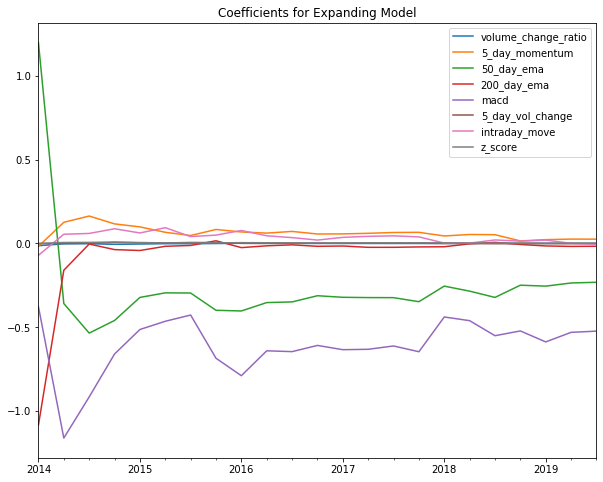

In [13]:
# Create a function to graph a time series of the coefficient values for each of the technical indicators
def extract_coefficients(models):
    coefficients = pd.DataFrame()
    for i, model in enumerate(models):
        ## Grab the coefficients from the linear regression model
        model_coefficients = pd.Series(model.coef_, index=["volume_change_ratio", "5_day_momentum", "50_day_ema", 
                                                           "200_day_ema", "macd", "5_day_vol_change", 
                                                           "intraday_move", "z_score"])
        model_coefficients.name = models.index[i]
        coefficients = pd.concat([coefficients, model_coefficients], axis=1, sort=False)
    return coefficients.T

# This graph helps to more easily show that the 50 day ema and macd indicators appear to have the strongest
# impact on the 5 day predictions made by the model
extract_coefficients(models).plot(title="Coefficients for Expanding Model", figsize=(10, 8))

In [14]:
import sklearn.metrics as metrics

# Get the same number of values for the y_pred and y_actual variables by dropping the NaN values
common_idx = y.dropna().index.intersection(predictions.dropna().index)
y_actual = y[common_idx]
y_actual.name = "y_actual"
y_pred = predictions[common_idx]
y_pred.name = "y_pred"

# Compute the statistical metrics for our model
standard_metrics = pd.Series()

standard_metrics.loc["Explained variance"] = metrics.explained_variance_score(y_actual, y_pred)
standard_metrics.loc["MAE"] = metrics.mean_absolute_error(y_actual, y_pred)
standard_metrics.loc["MSE"] = metrics.mean_squared_error(y_actual, y_pred)
standard_metrics.loc["R-Squared"] = metrics.r2_score(y_actual, y_pred)

print(standard_metrics)

Explained variance   -0.032684
MAE                   0.025934
MSE                   0.001277
R-Squared            -0.032990
dtype: float64


In [15]:
# Create a function to create a DataFrame with our y_pred and y_actual values as well as add columns to show whether
# the y_pred value was accurate in predicting the y_actual value and what the resulting return would be based on the
# prediction
def create_df(y_pred, y_actual):
    y_pred.name = "y_pred"
    y_actual.name = "y_actual"
    df = pd.concat([y_pred, y_actual], axis=1, sort="index")
    
    df["sign_pred"] = df.y_pred.apply(np.sign)
    df["sign_actual"] = df.y_actual.apply(np.sign)
    df["correct"] = 0
    df.loc[df.sign_pred * df.sign_actual > 0, "correct"] = 1
    df["incorrect"] = 0
    df.loc[df.sign_pred * df.sign_actual < 0, "incorrect"] = 1
    df["prediction"] = df.correct + df.incorrect
    df["result"] = df.sign_pred * df.y_actual
    return df

# A "1" in the "correct" column signifies a correct prediction of stock price direction for that ticker on that date
training_df = create_df(y_pred, y_actual)
print(training_df.tail(10))

                     y_pred  y_actual  sign_pred  sign_actual  correct  \
Date       Symbol                                                        
2019-11-27 AAPL   -0.000834 -0.008510       -1.0         -1.0        1   
           AMZN    0.002603 -0.043326        1.0         -1.0        0   
           FB      0.003455 -0.013207        1.0         -1.0        0   
           GOOGL   0.005594  0.011274        1.0          1.0        1   
           MSFT    0.003507 -0.015690        1.0         -1.0        0   
2019-11-29 AAPL    0.000617  0.012978        1.0          1.0        1   
           AMZN    0.006101 -0.027066        1.0         -1.0        0   
           FB      0.005007 -0.002927        1.0         -1.0        0   
           GOOGL   0.006883  0.027017        1.0          1.0        1   
           MSFT    0.005118  0.002433        1.0          1.0        1   

                   incorrect  prediction    result  
Date       Symbol                                   
2019-

In [16]:
# Create a function to calculate some custom metrics for our model
def analysis_metrics(df):
    analysis = pd.Series()
    
    ## accuracy measures the $ of correct predictions
    ## expected_weekly_return_% measures the average weekly return as a % if each stock was equally invested
    ## noise estimates how dramatic the predictions vary day to day (extremely small is better)  
    ## prediction_calibration is a ratio that measures the average magnitude of the y_pred values vs. the y_actual
    ## values and indicates how well the model reflects the size of the actual stock movements (close to 1.0 is ideal)
    analysis.loc["accuracy"] = (df.correct.sum()*1 / df.prediction.sum()*1) * 100
    analysis.loc["expected_5_day_%_return"] = df.result.mean() * 100 
    analysis.loc["noise"] = df.y_pred.diff().abs().mean()
    analysis.loc["prediction_calibration"] = df.y_pred.abs().mean() / df.y_actual.abs().mean()
    analysis.loc["%_return_long"] = df[df.sign_pred == 1].result.mean() * 100
    analysis.loc["%_return_short"] = df[df.sign_pred == -1].result.mean() * 100
    return analysis

analysis = analysis_metrics(training_df)
print(analysis)

accuracy                   56.632582
expected_5_day_%_return     0.423346
noise                       0.005584
prediction_calibration      0.248268
%_return_long               0.563509
%_return_short             -0.263466
dtype: float64


In [17]:
# Create a function to show the custom analysis metrics from the analysis_metrics function by year
def results_by_year(df):
    df["Year"] = df.index.get_level_values("Date").year
    return df.groupby("Year").apply(analysis_metrics).T

yearly_results = results_by_year(training_df)
print(yearly_results)

Year                          2014       2015       2016       2017  \
accuracy                 48.484848  55.043685  53.852264  63.397129   
expected_5_day_%_return  -0.024741   0.516258   0.327454   0.729681   
noise                     0.014327   0.006228   0.003799   0.002596   
prediction_calibration    0.419498   0.177078   0.267816   0.240095   
%_return_long             0.245845   0.868511   0.391448   0.823009   
%_return_short           -0.522683  -0.238321  -0.383856  -0.507967   

Year                          2018       2019  
accuracy                 56.494024  60.952381  
expected_5_day_%_return   0.140595   0.773403  
noise                     0.005028   0.003402  
prediction_calibration    0.223345   0.206367  
%_return_long             0.121071   0.879199  
%_return_short            0.288900  -0.032698  


In [18]:
# Create a function to show the custom analysis metrics from the analysis_metrics function by month
def results_by_month(df):
    df["Month"] = df.index.get_level_values("Date").month
    return df.groupby("Month").apply(analysis_metrics).T

average_monthly_results = results_by_month(training_df)
average_monthly_results = average_monthly_results.rename(columns={1: "Jan",
                                                                  2: "Feb",
                                                                  3: "Mar",
                                                                  4: "Apr",
                                                                  5: "May",
                                                                  6: "June",
                                                                  7: "July",
                                                                  8: "Aug",
                                                                  9: "Sept",
                                                                  10: "Oct",
                                                                  11: "Nov",
                                                                  12: "Dec"})
print(average_monthly_results)

Month                          Jan        Feb        Mar        Apr  \
accuracy                 58.613861  60.208333  61.818182  62.419355   
expected_5_day_%_return   0.551353   0.527566   0.557170   0.826235   
noise                     0.005354   0.006101   0.005139   0.006076   
prediction_calibration    0.202451   0.257608   0.218267   0.199364   
%_return_long             0.904426   0.938867   0.506542   1.011176   
%_return_short           -2.223678  -1.139282   0.752964   0.031147   

Month                          May       June       July        Aug  \
accuracy                 55.156250  48.902821  64.094488  54.367470   
expected_5_day_%_return   0.264957   0.154578   1.125190   0.294171   
noise                     0.007821   0.010406   0.004747   0.004802   
prediction_calibration    0.343069   0.454462   0.145638   0.265445   
%_return_long             0.522855   0.301827   1.411564   0.351184   
%_return_short           -0.830053  -0.496810  -0.116569   0.054980   

Mont

In [19]:
# Create a function to show the custom analysis metrics from the analysis_metrics function by symbol
def results_by_symbol(df):
    #df["Sym"] = df.index.get_level_values("Date").year
    return df.groupby("Symbol").apply(analysis_metrics).T

symbol_results = results_by_symbol(training_df)
print(symbol_results)

Symbol                        AAPL       AMZN         FB      GOOGL       MSFT
accuracy                 54.131653  53.743877  57.563025  57.942617  59.789474
expected_5_day_%_return   0.191472   0.344801   0.539696   0.474967   0.565792
noise                     0.002543   0.002971   0.002631   0.002120   0.002364
prediction_calibration    0.240856   0.237158   0.238715   0.259554   0.271979
%_return_long             0.457777   0.703811   0.584630   0.457217   0.631147
%_return_short           -0.754165  -0.556691   0.211310   0.635842   0.100504


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, Lasso, Ridge

# Use test_size=1235 to make roughly the last 12 months of data as the test data
X_train, X_test, y_train, y_test = train_test_split(indicators, outcomes.day_5, test_size=1235, shuffle=False)

# Get rid of any NaN or infinity values
Xy_train = X_train.join(y_train).dropna()
Xy_train = Xy_train.replace([np.inf, -np.inf], np.nan).dropna()
X_train_adjust = Xy_train[X_train.columns]
y_train_adjust = Xy_train[y_train.name]

Xy_test = X_test.join(y_test).dropna()
Xy_test = Xy_test.replace([np.inf, -np.inf], np.nan).dropna()
X_test_adjust = Xy_test[X_test.columns]
y_test_adjust = Xy_test[y_test.name]

# Linear Regression model
model1 = LinearRegression().fit(X_train_adjust, y_train_adjust)
model1_train = pd.Series(model1.predict(X_train_adjust), index=X_train_adjust.index)
model1_test = pd.Series(model1.predict(X_test_adjust), index=X_test_adjust.index)

# Create a DataFrame of each model that contains the analysis metrics
model1_train_df = create_df(model1_train, y_train_adjust)
model1_test_df = create_df(model1_test, y_test_adjust)

results1 = analysis_metrics(model1_train_df)
results1.name = "model1_train"
results2 = analysis_metrics(model1_test_df)
results2.name = "model1_test"

print(pd.concat([results1, results2], axis=1))

                         model1_train  model1_test
accuracy                    57.433975    59.669421
expected_5_day_%_return      0.481460     0.700906
noise                        0.003275     0.003357
prediction_calibration       0.200400     0.203633
%_return_long                0.524030     0.818000
%_return_short               0.103128    -0.114135


In [21]:
# Create a function to output the models and predictions from our walk forward model
def create_prediction_model(X, y, algo=LinearRegression()):
    return models, predictions

linear_models, linear_predictions = create_prediction_model(X, y, algo=LinearRegression())

In [22]:
# The model retrains on a quarterly basis
print("Models:")
print(linear_models.tail())

Models:
2018-09-30    LinearRegression(copy_X=True, fit_intercept=Tr...
2018-12-31    LinearRegression(copy_X=True, fit_intercept=Tr...
2019-03-31    LinearRegression(copy_X=True, fit_intercept=Tr...
2019-06-30    LinearRegression(copy_X=True, fit_intercept=Tr...
2019-09-30    LinearRegression(copy_X=True, fit_intercept=Tr...
dtype: object


In [23]:
# The predictions are forecasting the directional price movement on a forward rolling 5 day period
# Ex: The prediction on "2019-11-08" is predicting the directional price movement from the closing price on 
# "2019-11-08" to the closing price on "2019-11-15"
print("Predictions:")
print(linear_predictions.apply(lambda x: '%.7f' % x).dropna().tail(30))

Predictions:
Date        Symbol
2019-11-29  AAPL       0.0006169
            AMZN       0.0061009
            FB         0.0050066
            GOOGL      0.0068825
            MSFT       0.0051179
2019-12-02  AAPL       0.0016655
            AMZN       0.0071225
            FB         0.0064040
            GOOGL      0.0083102
            MSFT       0.0059717
2019-12-03  AAPL       0.0039047
            AMZN       0.0082853
            FB         0.0073848
            GOOGL      0.0062024
            MSFT       0.0061370
2019-12-04  AAPL       0.0027060
            AMZN       0.0087223
            FB         0.0074228
            GOOGL      0.0021395
            MSFT       0.0056485
2019-12-05  AAPL      -0.0011784
            AMZN       0.0096448
            FB         0.0063354
            GOOGL      0.0021038
            MSFT       0.0046712
2019-12-06  AAPL      -0.0058569
            AMZN       0.0069566
            FB         0.0037925
            GOOGL     -0.0004127
           

In [24]:
# Combine our "create_df" function and "analysis_metrics" function into one function
def prediction_metrics(y_pred, y_actual):

    def create_df(y_pred, y_actual):
        y_pred.name = "y_pred"
        y_actual.name = "y_actual"
        df = pd.concat([y_pred, y_actual], axis=1, sort="index").dropna()

        df["sign_pred"] = df.y_pred.apply(np.sign)
        df["sign_actual"] = df.y_actual.apply(np.sign)
        df["correct"] = 0
        df.loc[df.sign_pred * df.sign_actual > 0, "correct"] = 1
        df["incorrect"] = 0
        df.loc[df.sign_pred * df.sign_actual < 0, "incorrect"] = 1
        df["prediction"] = df.correct + df.incorrect
        df["result"] = df.sign_pred * df.y_actual
        return df
    
    df = create_df(y_pred, y_actual)
    
    analysis = pd.Series()

    analysis.loc["Explained variance"] = metrics.explained_variance_score(df.y_actual, df.y_pred)
    analysis.loc["MAE"] = metrics.mean_absolute_error(df.y_actual, df.y_pred)
    analysis.loc["R-Squared"] = metrics.r2_score(df.y_actual, df.y_pred)
    analysis.loc["accuracy"] = (df.correct.sum()*1 / df.prediction.sum()*1) * 100
    analysis.loc["expected_5_day_%_return"] = df.result.mean() * 100 
    analysis.loc["noise"] = df.y_pred.diff().abs().mean()
    analysis.loc["prediction_calibration"] = df.y_pred.abs().mean() / df.y_actual.abs().mean()
    analysis.loc["%_return_long"] = df[df.sign_pred == 1].result.mean() * 100
    analysis.loc["%_return_short"] = df[df.sign_pred == -1].result.mean() * 100

    return analysis

prediction_metrics(y_pred=linear_predictions, y_actual=y)

Explained variance         -0.032684
MAE                         0.025934
R-Squared                  -0.032990
accuracy                   56.632582
expected_5_day_%_return     0.423346
noise                       0.005584
prediction_calibration      0.248268
%_return_long               0.563509
%_return_short             -0.263466
dtype: float64

In [25]:
# Show a breakdown of the analysis metrics for the last 4 quarters of predictions
def metrics_by_quarter(y_pred, y_actual):
    df = pd.concat([y_pred, y_actual], axis=1).dropna().reset_index().set_index("Date")
    quarterly_analysis = df.resample("Q").apply(lambda df: prediction_metrics(df[y_pred.name], df[y_actual.name]))
    return quarterly_analysis

quarterly_metrics = metrics_by_quarter(y_pred=linear_predictions, y_actual=y)
print(quarterly_metrics.tail(4).T)

Date                     2019-03-31  2019-06-30  2019-09-30  2019-12-31
Explained variance         0.067914   -0.006295    0.030449    0.002783
MAE                        0.024535    0.028301    0.022138    0.016863
R-Squared                 -0.062317   -0.008487   -0.009780   -0.124787
accuracy                  70.491803   57.142857   52.187500   66.046512
expected_5_day_%_return    1.705214    0.380417    0.187095    0.899948
noise                      0.003719    0.003368    0.002960    0.003678
prediction_calibration     0.187758    0.153734    0.259442    0.269984
%_return_long              1.926828    0.545864    0.090429    1.157405
%_return_short             0.317490   -0.368447    2.668191   -1.249258


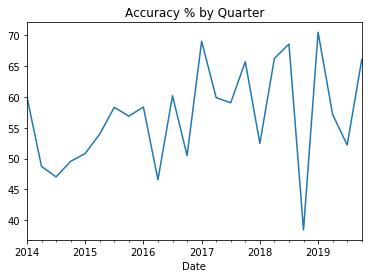

In [26]:
# Chart the accuracy over time on a quarterly basis
quarterly_metrics["accuracy"].plot(title="Accuracy % by Quarter")

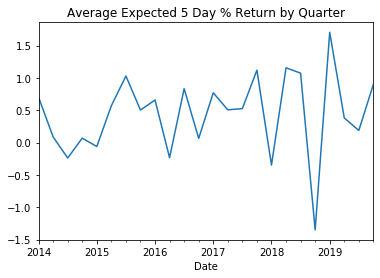

In [27]:
# Chart the expected_weekly_return_% over time on a quarterly basis
quarterly_metrics["expected_5_day_%_return"].plot(title="Average Expected 5 Day % Return by Quarter")

In [28]:
print(outcomes["day_5"].tail(35))

Date        Symbol
2019-11-27  AAPL     -0.008510
            AMZN     -0.043326
            FB       -0.013207
            GOOGL     0.011274
            MSFT     -0.015690
2019-11-29  AAPL      0.012978
            AMZN     -0.027066
            FB       -0.002927
            GOOGL     0.027017
            MSFT      0.002433
2019-12-02  AAPL           NaN
            AMZN           NaN
            FB             NaN
            GOOGL          NaN
            MSFT           NaN
2019-12-03  AAPL           NaN
            AMZN           NaN
            FB             NaN
            GOOGL          NaN
            MSFT           NaN
2019-12-04  AAPL           NaN
            AMZN           NaN
            FB             NaN
            GOOGL          NaN
            MSFT           NaN
2019-12-05  AAPL           NaN
            AMZN           NaN
            FB             NaN
            GOOGL          NaN
            MSFT           NaN
2019-12-06  AAPL           NaN
            AMZN    